<a href="https://colab.research.google.com/github/luciana11levy/coder/blob/main/Data_Science_III_Poemas_Luciana_Levy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Primera parte: Utilización de NLP en poemas

In [1]:
! python -m spacy download es_core_news_sm
! pip install -U symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 103.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 12.7 MB/s eta 0:00:00


In [2]:
import nltk # importar natural language toolkit
nltk.download('punkt')
nltk.download('stopwords') # modulo para descargar stopwords en diferentes idiomas
nltk.download('wordnet')
from nltk.corpus import stopwords
import pandas as pd
import numpy  as np
import re
import string
import plotly
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import time
import spacy
import es_core_news_sm
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from wordcloud import WordCloud
import pickle
from symspellpy import SymSpell
import pkg_resources
from symspellpy import SymSpell, Verbosity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-2-cc7f8c20a4bf>:23: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [5]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/PoetryFoundationData.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/poetry')

Mounted at /content/drive


In [6]:

import pandas as pd

# Lee el archivo CSV
df = pd.read_csv('/content/sample_data/poetry/PoetryFoundationData.csv')

#Mostrar las primeras filas del contenido
print(df.head())

   Unnamed: 0                                              Title  \
0           0  \r\r\n                    Objects Used to Prop...   
1           1  \r\r\n                    The New Church\r\r\n...   
2           2  \r\r\n                    Look for Me\r\r\n   ...   
3           3  \r\r\n                    Wild Life\r\r\n     ...   
4           4  \r\r\n                    Umbrella\r\r\n      ...   

                                                Poem              Poet Tags  
0  \r\r\nDog bone, stapler,\r\r\ncribbage board, ...  Michelle Menting  NaN  
1  \r\r\nThe old cupola glinted above the clouds,...     Lucia Cherciu  NaN  
2  \r\r\nLook for me under the hood\r\r\nof that ...        Ted Kooser  NaN  
3  \r\r\nBehind the silo, the Mother Rabbit\r\r\n...   Grace Cavalieri  NaN  
4  \r\r\nWhen I push your button\r\r\nyou fly off...      Connie Wanek  NaN  


In [7]:
 #1. Contar la cantidad de poemas por autor
print("\nCantidad de poemas por autor:")
print(df['Poet'].value_counts())



Cantidad de poemas por autor:
Poet
William Shakespeare      85
Alfred, Lord Tennyson    73
Emily Dickinson          51
William Wordsworth       51
Rae Armantrout           49
                         ..
Thomas Pfau               1
Alissa Leigh              1
Chrissy Williams          1
Lieke Marsman             1
Jane Huffman              1
Name: count, Length: 3128, dtype: int64


In [8]:
# 2. Mostrar los 10 poemas más largos (por cantidad de palabras)
df['word_count'] = df['Poem'].apply(lambda x: len(x.split()))
print("\nLos 10 poemas más largos:")
print(df.sort_values('word_count', ascending=False).head(10)[['Title', 'Poet', 'word_count']])



Los 10 poemas más largos:
                                                   Title                 Poet  \
13065  \r\r\n                    Song of Myself (1892...         Walt Whitman   
2392   \r\r\n                    Venus and Adonis\r\r...  William Shakespeare   
9330   \r\r\n                    Scenes of Life at th...        Philip Whalen   
7359   \r\r\nParadise Lost: Book  9 (1674 version)\r\...          John Milton   
897    \r\r\nParadise Lost: Book 10 (1674 version)\r\...          John Milton   
891    \r\r\nParadise Lost: Book  2 (1674 version)\r\...          John Milton   
8411   \r\r\n                    The Glass Essay\r\r\...          Anne Carson   
893    \r\r\nParadise Lost: Book  4 (1674 version)\r\...          John Milton   
7033   \r\r\n                    Absalom and Achitoph...          John Dryden   
12554  \r\r\n                    Sohrab and Rustum\r\...       Matthew Arnold   

       word_count  
13065       15713  
2392         9713  
9330         9451  
7

In [11]:
# Análisis de frecuencia de palabras usando NLTK
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt_tab')

all_words = []
# Assign stopwords to a variable called stop_words
stop_words = set(stopwords.words('english'))
for poem in df['Poem']:
    words = word_tokenize(poem.lower())
    words = [w for w in words if w.isalnum() and w not in stop_words]
    all_words.extend(words)

word_freq = nltk.FreqDist(all_words)

print("\nPalabras más frecuentes:")
print(word_freq.most_common(20)) # Muestra las 20 palabras más comunes


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Palabras más frecuentes:
[('like', 14819), ('one', 11787), ('us', 6154), ('love', 5785), ('would', 5552), ('time', 5010), ('man', 4883), ('know', 4867), ('back', 4864), ('could', 4835), ('see', 4804), ('night', 4653), ('day', 4522), ('still', 4472), ('light', 4389), ('never', 4191), ('life', 4166), ('said', 4160), ('eyes', 4059), ('way', 3943)]


In [12]:
# Lemmatización

import nltk
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df['lemmatized_poem'] = df['Poem'].apply(lambda poem: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(poem.lower())]))

print(df[['Poem', 'lemmatized_poem']].head())


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


                                                Poem  \
0  \r\r\nDog bone, stapler,\r\r\ncribbage board, ...   
1  \r\r\nThe old cupola glinted above the clouds,...   
2  \r\r\nLook for me under the hood\r\r\nof that ...   
3  \r\r\nBehind the silo, the Mother Rabbit\r\r\n...   
4  \r\r\nWhen I push your button\r\r\nyou fly off...   

                                     lemmatized_poem  
0  dog bone , stapler , cribbage board , garlic p...  
1  the old cupola glinted above the cloud , shone...  
2  look for me under the hood of that old chevrol...  
3  behind the silo , the mother rabbit hunch like...  
4  when i push your button you fly off the handle...  


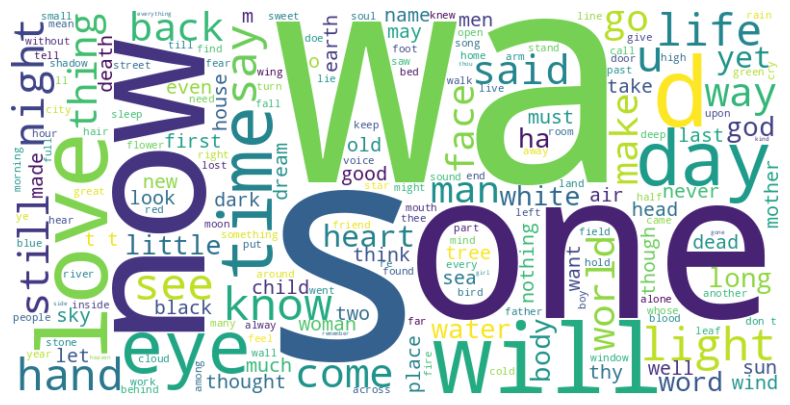

In [13]:
#WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt


text = " ".join(df['lemmatized_poem'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# Segunda parte: Utilización de deep learning con detección de signos

In [35]:
!pip install h5py
import h5py

In [36]:
import h5py
import zipfile # Importing the zipfile module

with zipfile.ZipFile('/Signs_Data_Testing.h5 (2).zip', 'r') as zip_ref:
  zip_ref.extractall('/content/sample_data/signs_data')

with h5py.File('/content/sample_data/signs_data/Signs_Data_Testing.h5', 'r') as hf:
  # Explore the contents of the HDF5 file
  print(hf.keys())




<KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>


In [37]:

with zipfile.ZipFile('/Signs_Data_Training.h5.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/sample_data/signs_data')

with h5py.File('/content/sample_data/signs_data/Signs_Data_Training.h5', 'r') as hf:
  # Explore the contents of the HDF5 file
  print(hf.keys())


<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform, GlorotUniform
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
from sklearn.metrics import classification_report

In [39]:
import h5py

# Load training data
with h5py.File('/content/sample_data/signs_data/Signs_Data_Training.h5', 'r') as hf:
    train_data = {
        'train_set_x': hf['train_set_x'][:],
        'train_set_y': hf['train_set_y'][:]
    }

# Load testing data
with h5py.File('/content/sample_data/signs_data/Signs_Data_Testing.h5', 'r') as hf:
    test_data = {
        'test_set_x': hf['test_set_x'][:],
        'test_set_y': hf['test_set_y'][:]
    }

x_train = train_data['train_set_x']
y_train = train_data['train_set_y']
x_test = test_data['test_set_x']
y_test = test_data['test_set_y']

In [40]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1080, 64, 64, 3), (1080,), (120, 64, 64, 3), (120,))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.1729 - loss: 1.8046 - val_accuracy: 0.2167 - val_loss: 1.7903
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.1738 - loss: 1.7898 - val_accuracy: 0.2250 - val_loss: 1.7715
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.2326 - loss: 1.7450 - val_accuracy: 0.5250 - val_loss: 1.3602
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4090 - loss: 1.4766 - val_accuracy: 0.4750 - val_loss: 1.3218
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.4845 - loss: 1.3136 - val_accuracy: 0.5833 - val_loss: 0.9887
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.5170 - loss: 1.2232 - val_accuracy: 0.6833 - val_loss: 0.8445
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6286 - loss: 0.9896 - val_accuracy: 0.8250 - val_loss: 0.7047
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6524 - loss: 0.9595 - val_accuracy: 0.8417 - val_loss: 0

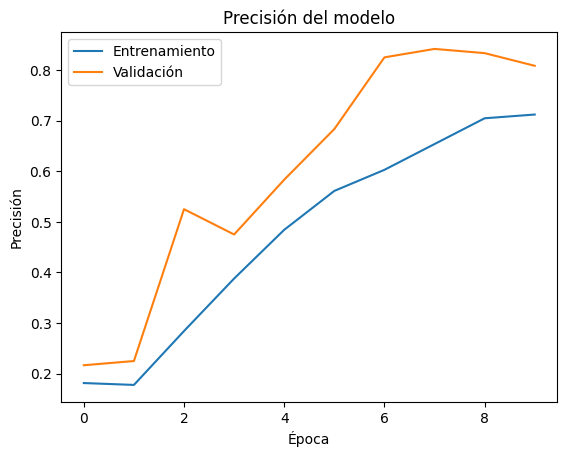

In [41]:

x_train = x_train.astype('float32') / 255.0  # Escalar los datos al rango [0, 1]
x_test = x_test.astype('float32') / 255.0

# Ensure y_train and y_test are 1D arrays of class labels before applying to_categorical
y_train = y_train.ravel()  # Flatten y_train if it's not already 1D
y_test = y_test.ravel()   # Flatten y_test if it's not already 1D

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=6)  # Convertir las etiquetas a one-hot encoding
y_test = to_categorical(y_test, num_classes=6)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)


# Definir el modelo CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),  # Utilizar data augmentation
    epochs=10,
    validation_data=(x_test, y_test)
)

# Evaluar el modelo
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', accuracy)

# Mostrar la gráfica de la precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()



In [42]:
from sklearn.metrics import classification_report


y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


report = classification_report(y_true, y_pred_classes)
print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.82      0.70      0.76        20
           2       0.67      0.40      0.50        20
           3       0.69      0.90      0.78        20
           4       0.76      0.95      0.84        20
           5       0.95      0.90      0.92        20

    accuracy                           0.81       120
   macro avg       0.81      0.81      0.80       120
weighted avg       0.81      0.81      0.80       120

